# Implementación del Desafío 2 (PNL1)

**Alumno:**
- Adassus, Luciano (CEIA 17Co2024)

**Objetivo:**

El objetivo de este trabajo es crear vectores de palabras propios utilizando **Word2Vec de Gensim**, entrenados sobre el texto literario completo de *Don Quijote de la Mancha*. Para lograrlo, se realizó un preprocesamiento del corpus, segmentando el contenido en oraciones y tokens significativos, utilizando técnicas lingüísticas adecuadas con **spaCy**.

A partir del modelo entrenado, se exploró el **espacio de embeddings** obtenido mediante visualizaciones en 2D y 3D, empleando **PCA** y **TSNE**, con el fin de observar la distribución semántica de los vectores y los agrupamientos emergentes. Además, se evaluaron **similitudes entre términos clave** del universo narrativo de la obra, analizando sus contextos, relaciones y distancias dentro del espacio vectorial.


In [ ]:
# Si es necesario instalar las siguientes libs y restart session runtime
!pip install spacy
!pip install gensim

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import numpy as np
import requests
import spacy
import importlib.util
import plotly.express as px

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE



### 1 - Descargar el texto de Don Quijote

In [12]:
# Descargar texto de Don Quijote desde Project Gutenberg
url = "https://www.gutenberg.org/files/2000/2000-0.txt"
response = requests.get(url)
texto = response.text

# Guardar localmente
with open("don_quijote.txt", "w", encoding="utf-8") as f:
    f.write(texto)

print("Texto descargado correctamente.")


Texto descargado correctamente.


### 2 - Preprocesamiento con spaCy (tokenización por oraciones)

In [13]:
# Verificar y cargar modelo de spaCy
model_name = "es_core_news_sm"

if importlib.util.find_spec(model_name) is None:
    print(f"Modelo '{model_name}' no encontrado. Instalando...")
    from spacy.cli import download
    download(model_name)

nlp = spacy.load(model_name)
nlp.max_length = 2_500_000

# Leer texto
with open("don_quijote.txt", "r", encoding="utf-8") as f:
    corpus = f.read()

# Procesar con spaCy
doc = nlp(corpus)

# Tokenizar por oraciones y palabras
sentence_tokens = []
for sent in doc.sents:
    tokens = [token.text.lower() for token in sent if not token.is_punct and not token.is_space]
    if len(tokens) > 2:
        sentence_tokens.append(tokens)

print()
print("Cantidad de oraciones procesadas:", len(sentence_tokens))
print("Ejemplo de tokens:", sentence_tokens[100:105])



Cantidad de oraciones procesadas: 8771
Ejemplo de tokens: [['de', 'solisdán', 'a', 'don', 'quijote', 'de', 'la', 'mancha', 'soneto', 'maguer', 'señor', 'quijote', 'que', 'sandeces', 'vos', 'tengan', 'el', 'cerbelo', 'derrumbado', 'nunca', 'seréis', 'de', 'alguno', 'reprochado', 'por', 'home', 'de', 'obras', 'viles', 'y', 'soeces'], ['serán', 'vuesas', 'fazañas', 'los', 'joeces', 'pues', 'tuertos', 'desfaciendo', 'habéis', 'andado', 'siendo', 'vegadas', 'mil', 'apaleado', 'por', 'follones', 'cautivos', 'y', 'raheces'], ['y', 'si', 'la', 'vuesa', 'linda', 'dulcinea', 'desaguisado', 'contra', 'vos', 'comete', 'ni', 'a', 'vuesas', 'cuitas', 'muestra', 'buen', 'talante', 'en', 'tal', 'desmán', 'vueso', 'conorte', 'sea', 'que', 'sancho', 'panza', 'fue', 'mal', 'alcagüete', 'necio', 'él', 'dura', 'ella', 'y', 'vos', 'no', 'amante'], ['diálogo', 'entre', 'babieca', 'y', 'rocinante', 'soneto', 'b.', 'cómo', 'estáis', 'rocinante', 'tan', 'delgado', 'r.', 'porque', 'nunca', 'se', 'come', 'y', 's

### 3 - Callback de entrenamiento (loss por época)

In [14]:
# Callback para imprimir el loss después de cada época
class callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.loss_previous_step = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print(f"Loss after epoch {self.epoch}: {loss - self.loss_previous_step}")
        self.loss_previous_step = loss
        self.epoch += 1


### 4 - Entrenamiento del modelo Word2Vec

In [15]:
cores = multiprocessing.cpu_count()

model = Word2Vec(sentences=sentence_tokens,
                 vector_size=100,
                 window=5,
                 min_count=2,
                 workers=cores-1,
                 compute_loss=True)

model.train(sentence_tokens, total_examples=len(sentence_tokens), epochs=20, callbacks=[callback()], compute_loss=True)
model.save("word2vec_don_quijote_callback.model")


Loss after epoch 0: 656967.25
Loss after epoch 1: 632595.375
Loss after epoch 2: 608185.75
Loss after epoch 3: 583490.375
Loss after epoch 4: 562428.25
Loss after epoch 5: 547711.25
Loss after epoch 6: 533933.75
Loss after epoch 7: 463662.0
Loss after epoch 8: 446997.5
Loss after epoch 9: 439699.0
Loss after epoch 10: 432471.5
Loss after epoch 11: 425428.5
Loss after epoch 12: 421534.5
Loss after epoch 13: 416025.0
Loss after epoch 14: 412206.5
Loss after epoch 15: 408198.5
Loss after epoch 16: 402559.0
Loss after epoch 17: 343336.0
Loss after epoch 18: 341915.0
Loss after epoch 19: 339734.0


### 5 - Evaluación del modelo

In [16]:
model = Word2Vec.load("word2vec_don_quijote_callback.model")

palabras = ['quijote', 'sancho', 'caballero', 'aventura', 'molino']

for palabra in palabras:
    if palabra in model.wv:
        print(f"Palabras similares a '{palabra}':")
        print(model.wv.most_similar(palabra, topn=5))
        print()
    else:
        print(f"'{palabra}' no se encuentra en el vocabulario.\n")


Palabras similares a 'quijote':
[('jerónimo', 0.6784800887107849), ('luis', 0.6487954258918762), ('antonio', 0.6375201344490051), ('álvaro', 0.6199852228164673), ('fernando', 0.6072520613670349)]

Palabras similares a 'sancho':
[('teresa', 0.6194552183151245), ('ambrosio', 0.49916473031044006), ('juana', 0.4825865924358368), ('emerencia', 0.4699953496456146), ('ricote', 0.4588494300842285)]

Palabras similares a 'caballero':
[('caballería', 0.6603744029998779), ('ínclito', 0.6179542541503906), ('hidalgo', 0.5830357074737549), ('hombre', 0.547870397567749), ('capitán', 0.5049675703048706)]

Palabras similares a 'aventura':
[('famosa', 0.6673639416694641), ('historia', 0.6330806612968445), ('trata', 0.593955397605896), ('nueva', 0.5927115678787231), ('sierra', 0.5895965099334717)]

Palabras similares a 'molino':
[('verano', 0.7757065892219543), ('ojo', 0.7660039067268372), ('punta', 0.7630178928375244), ('alcornoque', 0.7496476769447327), ('arzón', 0.7446107268333435)]



**Conclusión:**

- Al evaluar las palabras clave (`quijote`, `sancho`, `caballero`, `aventura`, `molino`), observamos que el modelo Word2Vec entrenado con el texto de Don Quijote logra capturar relaciones semánticas coherentes dentro del contexto narrativo de la obra. Las palabras similares identificadas por el modelo reflejan coapariciones frecuentes y vínculos temáticos, como nombres de personajes, atributos de caballería o elementos de aventuras.

- También notamos que al aumentar la cantidad de épocas de entrenamiento, algunas similitudes se debilitan. Esto sugiere que el modelo puede sobreajustarse a patrones menos relevantes si se entrena en exceso sobre un corpus literario específico y limitado. En particular, términos como `'molino'` comienzan a asociarse con palabras menos intuitivas, lo cual puede deberse a baja frecuencia o alta variabilidad de contexto.

- En conjunto, los resultados muestran que el modelo es capaz de aprender representaciones útiles del lenguaje literario, aunque es importante balancear la cantidad de entrenamiento para preservar relaciones semánticas significativas.


### 6 - Ensayo: análisis semántico entre términos

In [17]:
# Analizar similitud entre pares de palabras específicas
pares = [
    ('quijote', 'sancho'),
    ('quijote', 'caballero'),
    ('quijote', 'molino'),
    ('caballero', 'aventura'),
    ('molino', 'aventura'),
    ('quijote', 'aventura'),
    ('quijote', 'dios'),
    ('molino', 'enemigo')
]

for w1, w2 in pares:
    if w1 in model.wv and w2 in model.wv:
        sim = model.wv.similarity(w1, w2)
        print(f"Similitud entre '{w1}' y '{w2}': {sim:.4f}")
    else:
        print(f"Una de las palabras no está en el vocabulario: '{w1}' o '{w2}'\n")


Similitud entre 'quijote' y 'sancho': 0.3924
Similitud entre 'quijote' y 'caballero': 0.2628
Similitud entre 'quijote' y 'molino': 0.1179
Similitud entre 'caballero' y 'aventura': 0.3159
Similitud entre 'molino' y 'aventura': 0.2810
Similitud entre 'quijote' y 'aventura': 0.1936
Similitud entre 'quijote' y 'dios': -0.0157
Similitud entre 'molino' y 'enemigo': 0.3244


**Conclusión:**

- Al evaluar las palabras clave (`quijote`, `sancho`, `caballero`, `aventura`, `molino`), observamos que el modelo Word2Vec entrenado con el texto de *Don Quijote* logra capturar relaciones semánticas coherentes dentro del universo narrativo de la obra.

- A través del análisis de similitud entre pares de palabras, se evidencian relaciones consistentes:

  - `'quijote'` y `'sancho'` presentan una similitud moderada (~0.39), lo cual es esperable dada su constante aparición conjunta.
  - `'caballero'` y `'aventura'` (~ 0.31) o `'molino'` y `'enemigo'` (~0.32), reflejan asociaciones narrativas típicas del contexto del libro.
  - Similitudes más bajas o negativas (como `'quijote'` y `'dios'`: -0.01) indican que no hay una relación semántica fuerte en el corpus entre esos términos.

- Algunas relaciones como `'quijote'` y `'molino'` (~0.11) son más débiles de lo esperado, probablemente debido a que `'molino'` aparece en un contexto muy puntual y no se repite con frecuencia suficiente para consolidar su vector en el espacio semántico.

- Estos resultados confirman que el modelo capta bien las asociaciones más fuertes del texto, pero también resaltan la sensibilidad del embedding a la frecuencia y variedad contextual de cada término.


### 7 - Visualización del espacio de embeddings (PSA)

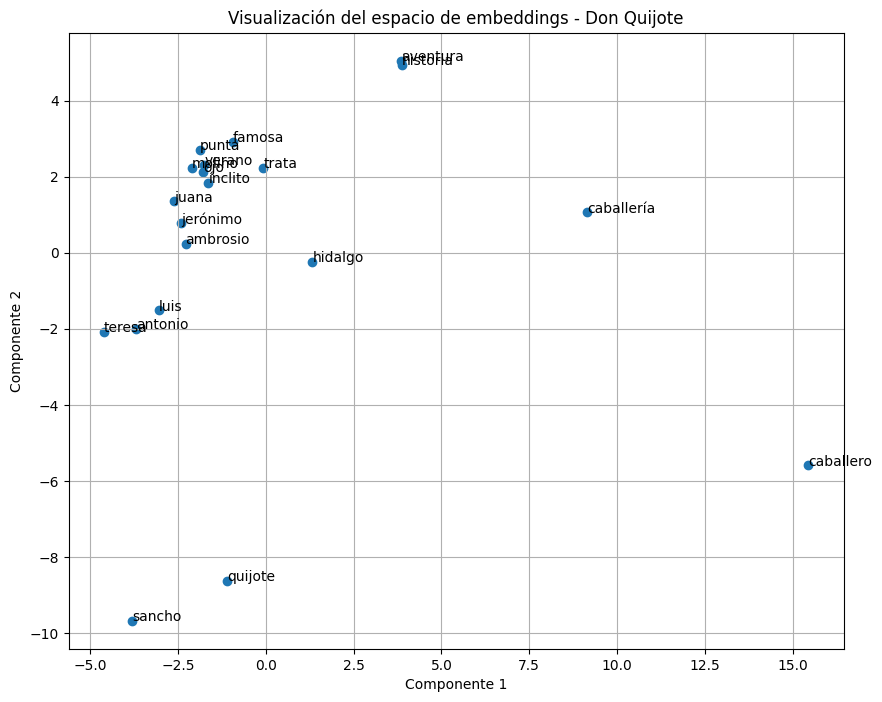

In [8]:
# Palabras a visualizar
palabras_a_visualizar = palabras.copy()
for palabra in palabras:
    if palabra in model.wv:
        palabras_a_visualizar += [w for w, _ in model.wv.most_similar(palabra, topn=3)]

# Eliminar duplicados
palabras_a_visualizar = list(set([p for p in palabras_a_visualizar if p in model.wv]))
embeddings = [model.wv[p] for p in palabras_a_visualizar]

# PCA
pca = PCA(n_components=2)
result = pca.fit_transform(embeddings)

# Graficar
plt.figure(figsize=(10, 8))
plt.scatter(result[:, 0], result[:, 1])
for i, palabra in enumerate(palabras_a_visualizar):
    plt.annotate(palabra, xy=(result[i, 0], result[i, 1]))
plt.title("Visualización del espacio de embeddings - Don Quijote")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()


### 8 - Visualización de la agrupación de vectores (TSNE)

**Visualización 2D:**

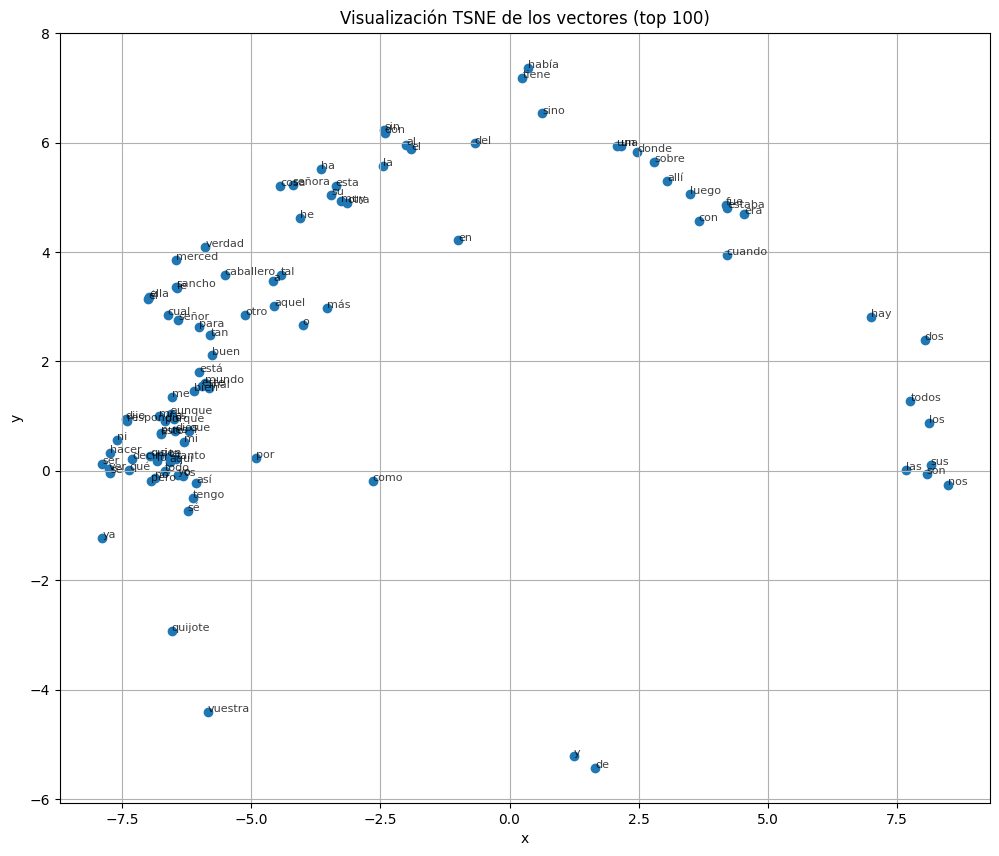

In [18]:
def reduce_dimensions(model, num_dimensions=2):
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=40, max_iter=300)
    reduced_vectors = tsne.fit_transform(vectors)

    return reduced_vectors, labels

# Reducir dimensiones a 2D para graficar
vec_2d, labels = reduce_dimensions(model)

# Graficar una muestra
# Versión legible del gráfico TSNE 2D con menos palabras
n = 100  # cantidad reducida
plt.figure(figsize=(12, 10))
plt.scatter(vec_2d[:n, 0], vec_2d[:n, 1])
for i in range(n):
    plt.annotate(labels[i], xy=(vec_2d[i, 0], vec_2d[i, 1]), fontsize=8, alpha=0.75)
plt.title("Visualización TSNE de los vectores (top 100)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()



**Visualización 3D:**

In [10]:
vecs_3d, labels_3d = reduce_dimensions(model, num_dimensions=3)
MAX_WORDS = 200

fig = px.scatter_3d(
    x=vecs_3d[:MAX_WORDS, 0],
    y=vecs_3d[:MAX_WORDS, 1],
    z=vecs_3d[:MAX_WORDS, 2],
    hover_name=labels_3d[:MAX_WORDS]
)

fig.update_traces(marker=dict(size=3, opacity=0.7))
fig.update_layout(
    title="Espacio de Embeddings 3D - TSNE",
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z',
        bgcolor='white'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    height=700
)
fig.show()


**Conclusiones sobre visualización del espacio de embeddings (2D y 3D):**

La visualización 2D permitió observar agrupamientos semánticos significativos dentro del modelo entrenado:

- Palabras funcionales (como *que*, *hacer*, *lo*, *ya*) aparecen juntas, lo que indica que el modelo las reconoce como de **uso común y gramatical**.
- Términos específicos como *quijote* y *vuestra* aparecen **aislados**, reflejando un uso más contextual o narrativo.
- Se identificaron **subgrupos semánticos**, como palabras de ubicación (*donde*, *allí*, *cuando*), cuantificadores (*dos*, *todos*, *sus*), o nombres comunes.

Por su parte, la visualización 3D refuerza esta interpretación al mostrar:

- Un **núcleo denso** de palabras frecuentes y funcionales.
- Algunos **clústeres separados** que podrían representar subconjuntos temáticos o entidades más específicas.
- La separación espacial facilita explorar relaciones menos evidentes en 2D.

Ambas visualizaciones complementan el análisis, mostrando que el modelo logró aprender un espacio semántico razonable a partir del texto de *Don Quijote*, donde la distribución refleja tanto **frecuencia** como **contexto de uso** de las palabras.
